# 🧾 EDA Summary in Python (IEEE-CIS Fraud Detection)

This notebook presents a lightweight version of the Exploratory Data Analysis (EDA) for the [IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection/data?select=train_transaction.csv) dataset. It replicates key steps from the R-based analysis using Python libraries for compatibility and reproducibility.

We focus on:
- Loading and merging data
- Basic data structure exploration
- Class imbalance analysis
- Selected visualizations

Our objective is to show key insights to stakeholders, a deep analysis is made in R in the [notebook .Rmd](./01_EDA_in_R.Rmd) of the notebooks folders in this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load and Merge Data

We load the datasets through `read_csv()` method from pandas. We use a left join to merge identity data into the transaction dataset. This ensures that all transactions are preserved, even if no associated identity information exists. Only ~24% of transactions have identity data, so a left join avoids losing valuable training samples.

In [2]:
transactions = pd.read_csv("../data/ieee-fraud-detection/train_transaction.csv")
identity = pd.read_csv("../data/ieee-fraud-detection/train_identity.csv")
train_data = transactions.merge(identity, on="TransactionID", how="left")
print(train_data.shape)

(590540, 434)


# 2. Dataset Overview (shape, missing values, basic info)

We begin by exploring the general structure of the dataset, including:
- The number of rows and columns after merging (590,540 × 434).
- The overall data types distribution (float64, int64, and object).
- The memory footprint (~1.9 GB), which is important for downstream modeling performance and scaling.

We also analyze missing values across all features.

In [3]:
print(train_data.shape)
print(train_data.info())
print(train_data.isnull().mean().sort_values(ascending=False).head(10))

(590540, 434)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB
None
id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
dtype: float64


### 2.1 Missing Values Summary Plot

We calculated the ratio of missing values for each feature and visualized the top 30 with the highest proportion.
- Several identity-related features (id_24, id_25, id_07, etc.) have over 99% missing values.
- Delay-related features like D13, D14, and some address proxies (D6, D33) also exhibit over 80% missingness.
- This sparsity implies:
  - Many features are incomplete and will require imputation, dropping, or special encoding strategies.
  
  - The data is likely collected from multiple sources or systems, leading to heterogeneous completeness.

This analysis helps prioritize which variables are worth retaining and which may contribute noise in early modeling phases.

/var/folders/c1/dqnthbv51f77zq628dg5d97h0000gn/T/ipykernel_99296/405693644.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_ratio.values, y=missing_ratio.index, palette="coolwarm")


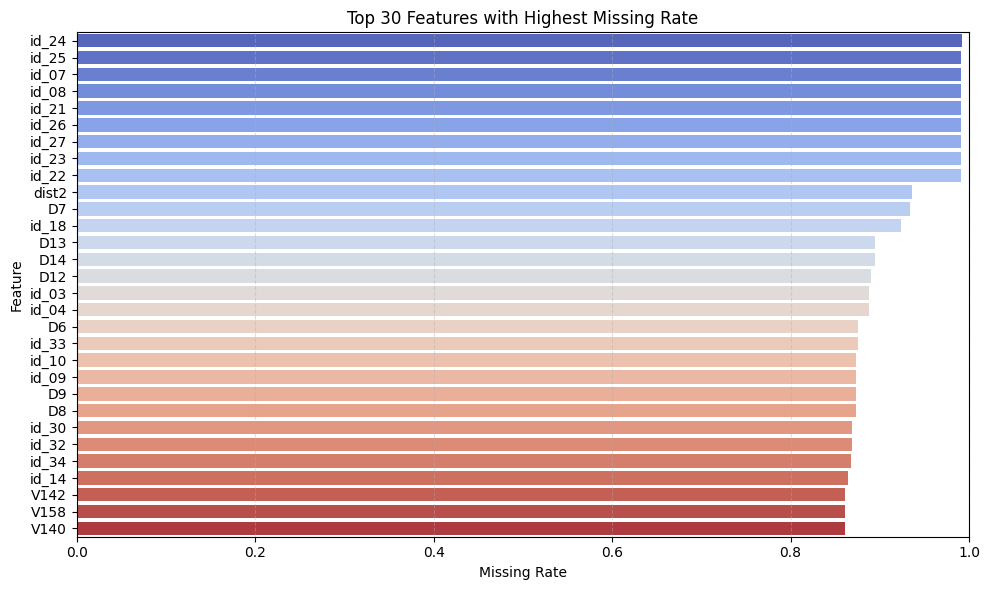

In [4]:
# Calculate missing value ratio
missing_ratio = train_data.isnull().mean().sort_values(ascending=False)[:30]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=missing_ratio.values, y=missing_ratio.index, palette="coolwarm")
plt.title("Top 30 Features with Highest Missing Rate")
plt.xlabel("Missing Rate")
plt.ylabel("Feature")
plt.xlim(0, 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 3. Target Variable Distribution

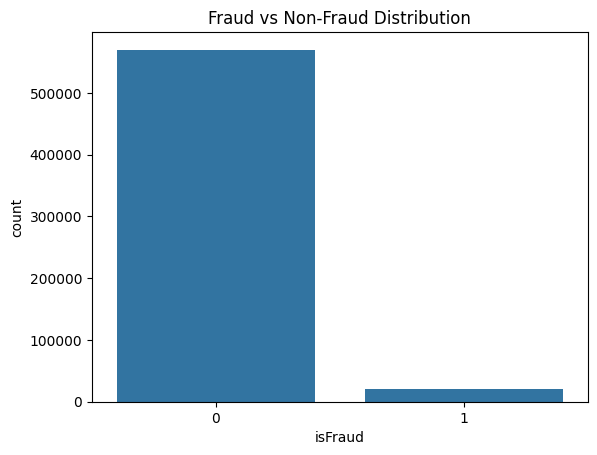

Fraud Rate: 3.50%


In [5]:
sns.countplot(x="isFraud", data=train_data)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

fraud_ratio = train_data["isFraud"].mean()
print(f"Fraud Rate: {fraud_ratio:.2%}")

🧠 Interpretation: Target Variable (isFraud)

This section analyzes the distribution of the target variable isFraud:
- 0 → Non-fraudulent transactions
- 1 → Fraudulent transactions

The bar plot shows a heavily imbalanced dataset, where fraud cases represent only ~3.5% of all transactions. This kind of imbalance is typical in fraud detection scenarios and has important modeling implications:
- Standard classifiers may be biased toward predicting the majority class.
- Special techniques (resampling, class weights, anomaly detection, etc.) will be needed to handle this.

The printed fraud rate confirms this:
➡️ Fraud Rate: ~3.50%


## 4. Transaction Amount Distribution (log scale)

💳 Transaction Amount Distribution

This plot shows the distribution of `TransactionAmt` (amount spent) for both fraudulent and non-fraudulent transactions. We apply a logarithmic scale to the x-axis to better visualize the highly skewed distribution.

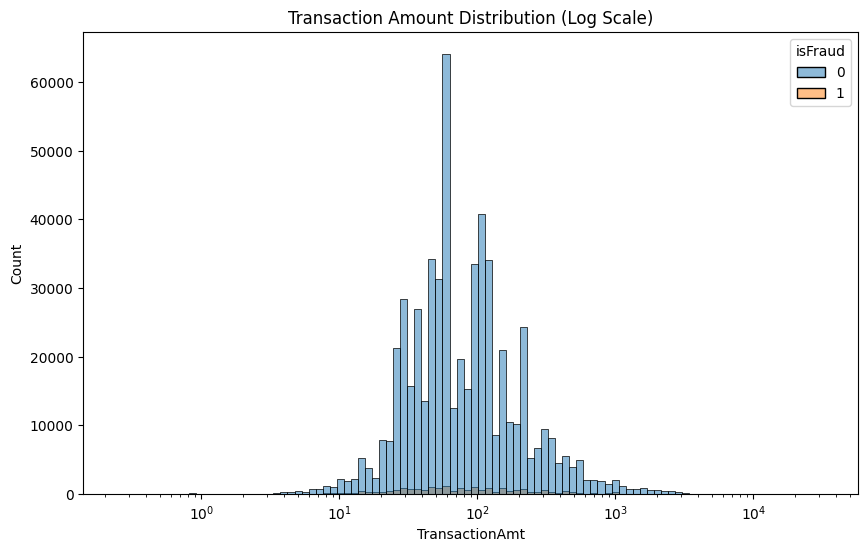

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(data=train_data, x="TransactionAmt", hue="isFraud", bins=100, log_scale=(True, False), alpha=0.5)
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()

Observations:
- Most transactions are concentrated between $10 and $500, with clear peaks around $100 and $50.
- Fraudulent transactions (in orange) tend to follow a similar pattern, but are much fewer in number.
- The spike near $100 suggests a common purchase amount, possibly making it harder to detect anomalies around that range.

Why log scale?
- The raw data contains extreme values (up to $10,000+).
- Log transformation helps compress those extremes and highlight patterns in smaller transaction ranges.

###  4.1 Transaction Amount Boxplot (Outlier Visualization)

This boxplot compares the distribution of `TransactionAmt` between fraudulent and non-fraudulent transactions. A logarithmic scale is applied to the y-axis to account for the high skewness in the data.

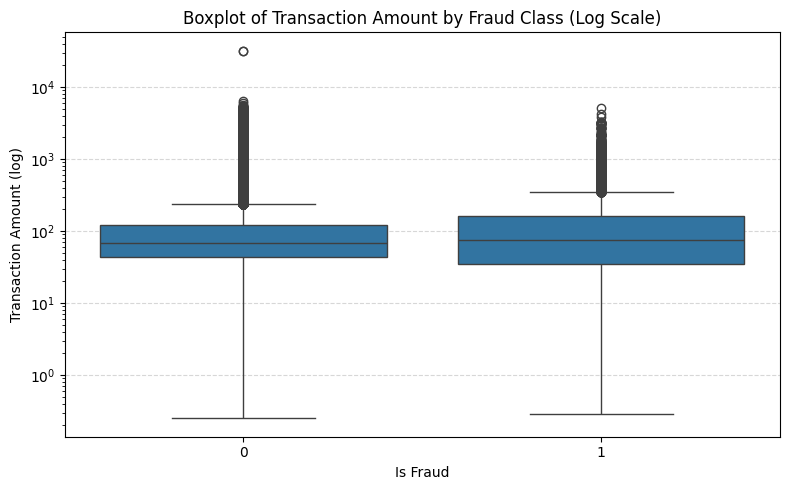

In [7]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_data, x="isFraud", y="TransactionAmt", showfliers=True)
plt.yscale("log")  # Optional: log scale to handle skewness
plt.title("Boxplot of Transaction Amount by Fraud Class (Log Scale)")
plt.xlabel("Is Fraud")
plt.ylabel("Transaction Amount (log)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observations**:
- Both classes exhibit similar interquartile ranges (IQR), suggesting typical transaction amounts are comparable.
- However, outliers in the fraudulent class extend more prominently beyond $1,000, with some transactions exceeding $10,000.
- This supports the hypothesis that high-value transactions are more likely to be fraudulent, although rare.
- The use of log scale highlights these anomalies while preserving interpretability of central tendencies.

**Takeaway**: Outlier behavior could be informative for anomaly detection or threshold-based rule design.

## 5. Temporal Pattern (summary)

The feature `TransactionDT` provides a time delta in seconds since a reference point. We derive the hour of the transaction using a modulo transformation to detect hourly behavioral patterns.

In [8]:
train_data['TransactionHour'] = (train_data['TransactionDT'] // 3600) % 24

### 5.1 Line Plot Temporal Pattern

We visualize the distribution of fraud and non-fraud transactions by hour using a normalized histogram (stat='probability').

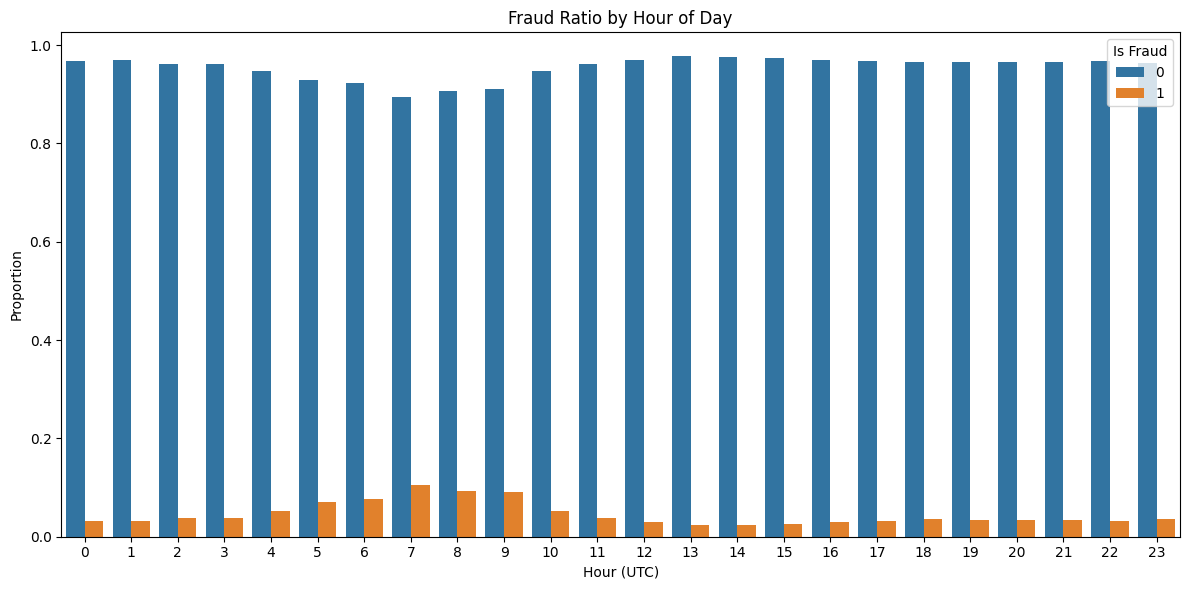

In [9]:
# Agrupamos y normalizamos
hourly_dist = (
    train_data.groupby(['TransactionHour', 'isFraud'])
    .size()
    .reset_index(name='count')
)

# Normalización por hora (proporciones)
hourly_total = hourly_dist.groupby('TransactionHour')['count'].transform('sum')
hourly_dist['proportion'] = hourly_dist['count'] / hourly_total

# Gráfico stacked normalized (tipo position="fill" en ggplot2)
plt.figure(figsize=(12,6))
sns.barplot(
    data=hourly_dist,
    x='TransactionHour',
    y='proportion',
    hue='isFraud'
)
plt.title("Fraud Ratio by Hour of Day")
plt.xlabel("Hour (UTC)")
plt.ylabel("Proportion")
plt.legend(title="Is Fraud")
plt.tight_layout()
plt.show()

🧠 Interpretation:
- Most transactions are concentrated between 12h and 23h UTC, with a visible dip around 6h–10h UTC.
- Fraudulent activity peaks between 6h and 9h UTC, which may indicate:
  - Bot or script activity scheduled in low-traffic periods.
  - Time zone effects in the transaction pattern.
- While fraud appears across all hours, this pattern may be useful for temporal feature engineering (e.g., IsMorning, IsNight, etc.).

### 5.2 Summary:

Although this simplified view doesn’t stack bars like the R version, it clearly shows time-based variations in fraud concentration, justifying further time-aware modeling.

## 6. Categorical Feature Insight

###  6.1 Categorical Feature Insights

- **Fraud Rate by ProductCD**

This plot shows the average fraud rate for each product code. Product code `C` has the highest fraud rate (over 12%), followed by `S` and `H`, while `W` and `R` show much lower fraud incidence.

These differences suggest that the nature of the product may influence the likelihood of fraud, possibly due to varying risk levels or transaction patterns across product types.

/var/folders/c1/dqnthbv51f77zq628dg5d97h0000gn/T/ipykernel_99296/1608703040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_data, x="ProductCD", y="isFraud", estimator=np.mean, palette="Set2")


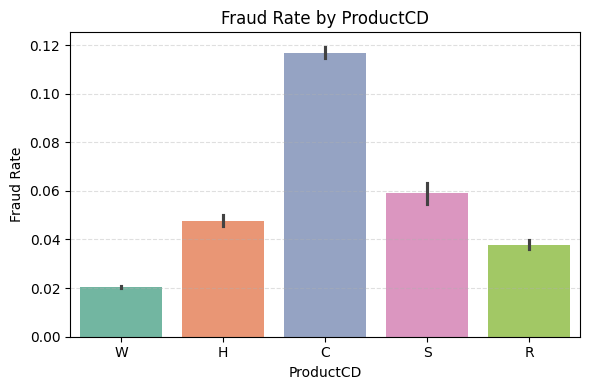

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(data=train_data, x="ProductCD", y="isFraud", estimator=np.mean, palette="Set2")
plt.title("Fraud Rate by ProductCD")
plt.ylabel("Fraud Rate")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

- **Fraud Rate by card6**

Here we analyze the fraud rate by card type. Transactions made with `credit` cards show a significantly higher fraud rate (~6.7%) compared to `debit` cards (~2.4%).

This aligns with patterns observed in financial fraud, where `credit` cards tend to be targeted more frequently due to higher spending limits and chargeback options.

/var/folders/c1/dqnthbv51f77zq628dg5d97h0000gn/T/ipykernel_99296/3421432366.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_data, x="card6", y="isFraud", estimator=np.mean, palette="Set3")


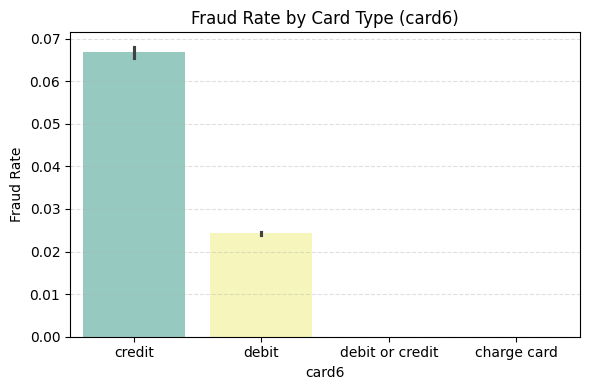

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(data=train_data, x="card6", y="isFraud", estimator=np.mean, palette="Set3")
plt.title("Fraud Rate by Card Type (card6)")
plt.ylabel("Fraud Rate")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 7. Final Remarks

### 🧠 **Key Takeaways**:

- **Class Imbalance**: The dataset is strongly imbalanced, with fraud comprising only **~3.5%** of all transactions. This requires careful handling with metrics like ROC-AUC or PR-AUC instead of accuracy.

- **Transaction Patterns**:
  - Fraudulent transactions tend to occur **disproportionately between 6–9 a.m. UTC**.
  - Amounts involved in fraud are typically **lower** on average, with some **outliers present** (long tail).
  
- **Categorical Signals**:
  - **ProductCD 'C'** shows a noticeably **higher fraud rate** compared to others.
  - **Card Type 'credit' (card6)** also exhibits a higher fraud proportion than debit or charge cards.

- **Missing Data**:
  - Many features, especially identity-related (`id_24`–`id_30`), have **over 90% missing values**.
  - Strategies such as selective imputation, feature pruning, or using tree-based models are advisable.

- **Dimensionality**:
  - With **434 columns** and many anonymized features, models must be robust to noise and sparsity.
  - Dimensionality reduction or strong feature selection (e.g. via random forest, SHAP, or autoencoders) is highly recommended.

---

### ✅ **Next Steps**:

- Integrate findings into **feature engineering pipeline** (temporal flags, categorical encodings, missingness indicators).
- Build **baseline models** using `Logistic Regression`, `Random Forest`, or `LightGBM`.
- Explore anomaly detection or resampling strategies to improve minority class recall.
- Continue documenting and tracking experiments using **MLflow** and good **version control practices**.